<a href="https://colab.research.google.com/github/JiaxinLi-lipluszn/Organized-Notebook/blob/main/Perturb_dataset_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import os
os.chdir("/content/drive/Shareddrives/Documentation/Data/Yale_Perturb/")

In [ ]:
#!unzip processed.zip

Archive:  processed.zip
replace __MACOSX/._processed? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
os.chdir("./processed")

In [ ]:
!pip install scanpy

In [ ]:
import scanpy
import pandas as pd

In [ ]:
sc_object = scanpy.read_h5ad("crispr_shallow.h5ad")

In [ ]:
sc_object

AnnData object with n_obs × n_vars = 16585 × 15125
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'leiden', 'feature_call', 'raw_scv2', 'Infected', 'new_feature_call', 'sgRNA', 'size', 'labels'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'Infected_colors', 'batch_colors', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Explain the meta file
* infected: idicating if the cell is effected by SARS CoVid virus (Not indicating if the cell has been perturbed)
* labels: Only 6435 cells are with labels, the labels distrubution are as below


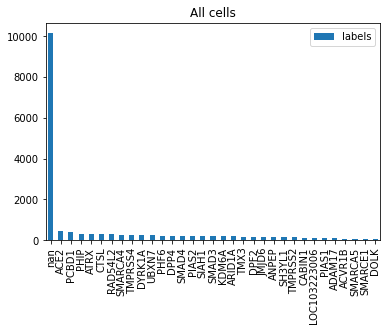

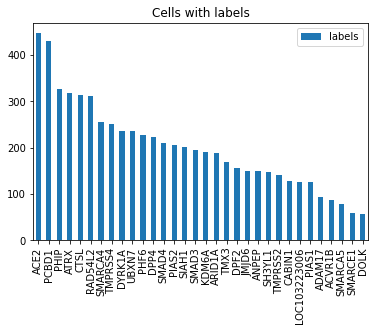

In [ ]:
x = pd.DataFrame(sc_object.obs['labels'].value_counts())
x.plot.bar(title = "All cells")
x.drop(index = "nan").plot.bar(title = "Cells with labels")

## Meta dataframe

In [ ]:
sc_object.obs

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,feature_call,raw_scv2,Infected,new_feature_call,sgRNA,size,labels
AAACCCAAGGTAATCA-1-SARS2,SARS2,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064,3,ACE2-4,1.0,Bystander,ACE2,ACE2,4,ACE2
AAACCCAAGTTGGAGC-1-SARS2,SARS2,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699,2,KDM6A-1,4.0,Bystander,KDM6A,Other guide,1,KDM6A
AAACCCAGTGGTGATG-1-SARS2,SARS2,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068,9,nan,14.0,Infected,None,None,1,nan
AAACGAAAGACCCGCT-1-SARS2,SARS2,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054,3,SMARCA4-1,2.0,Bystander,SMARCA4,Other guide,1,SMARCA4
AAACGAAAGGAAAGGT-1-SARS2,SARS2,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310,3,nan,11.0,Infected,None,None,1,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,MOCK,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283,1,nan,0.0,Mock,None,None,1,nan
TTTGTTGTCACCGCTT-1-MOCK,MOCK,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383,0,nan,0.0,Mock,None,None,1,nan
TTTGTTGTCCACTTTA-1-MOCK,MOCK,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331,0,PHF6-4,0.0,Mock,PHF6,Other guide,1,PHF6
TTTGTTGTCTCCGAGG-1-MOCK,MOCK,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556,4,nan,0.0,Mock,None,None,1,nan


# Information about genes

In [ ]:
sc_object.var.loc['ACE2',]

gene_ids                            ACE2
feature_types            Gene Expression
n_cells_by_counts                     76
mean_counts                   0.00419033
log1p_mean_counts             0.00418157
pct_dropout_by_counts             99.581
total_counts                          76
log1p_total_counts               4.34381
n_cells                               74
Name: ACE2, dtype: object

In [ ]:
sc_object.var

,gene_ids,feature_types,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells
BET1L,BET1L,Gene Expression,867,0.049402,0.048220,95.219717,896.0,6.799056,866
RIC8A,RIC8A,Gene Expression,566,0.031979,0.031478,96.879307,580.0,6.364751,566
SIRT3,SIRT3,Gene Expression,153,0.008546,0.008510,99.156421,155.0,5.049856,152
PSMD13,PSMD13,Gene Expression,2730,0.173568,0.160049,84.947897,3148.0,8.054840,2719
ATHL1,ATHL1,Gene Expression,56,0.003143,0.003138,99.691239,57.0,4.060443,56
...,...,...,...,...,...,...,...,...,...
RPGR,RPGR,Gene Expression,4,0.000221,0.000221,99.977946,4.0,1.609438,4
LOC103247444,LOC103247444,Gene Expression,3,0.000165,0.000165,99.983459,3.0,1.386294,3
DDX3Y,DDX3Y,Gene Expression,13,0.000717,0.000717,99.928323,13.0,2.639057,13
LOC103247455,LOC103247455,Gene Expression,7,0.000386,0.000386,99.961405,7.0,2.079442,7


In [ ]:
sc_object.obs['Infected'].value_counts()

Mock         12487
Bystander     2202
Infected      1896
Name: Infected, dtype: int64

In [ ]:
sc_object.obs['batch'].value_counts()

MOCK     12487
SARS2     4098
Name: batch, dtype: int64

# Expression matrix

In [ ]:
sc_object.X

<16585x15125 sparse matrix of type '<class 'numpy.float32'>'
	with 11243060 stored elements in Compressed Sparse Row format>

# EM algorithm to fit the importance of each perturbation
Adapted code based on https://github.com/asncd/MIMOSCA/blob/master/contrived-em_example.ipynb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
import sklearn
from sklearn import linear_model
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')

## Bayes_cov_col

In [ ]:
def bayes_cov_col(Y,X,cols,lm):
    """
    @Y    = Expression matrix, cells x x genes, expecting pandas dataframe
    @X    = Covariate matrix, cells x covariates, expecting pandas dataframe
    @cols = The subset of columns that the EM should be performed over, expecting list
    @lm   = linear model object
    """

    #EM iterateit
    Yhat=pd.DataFrame(lm.predict(X))
    Yhat.index=Y.index
    Yhat.columns=Y.columns
    SSE_all=np.square(Y.subtract(Yhat))
    X_adjust=X.copy()


    df_SSE   = []
    df_logit = []

    for curcov in cols:

        curcells=X[X[curcov]>0].index

        if len(curcells)>2:

            X_notcur=X.copy()
            X_notcur[curcov]=[0]*len(X_notcur)

            X_sub=X_notcur.loc[curcells]

            Y_sub=Y.loc[curcells]

            GENE_var=2.0*Y_sub.var(axis=0)
            vargenes=GENE_var[GENE_var>0].index

            Yhat_notcur=pd.DataFrame(lm.predict(X_sub))
            Yhat_notcur.index=Y_sub.index
            Yhat_notcur.columns=Y_sub.columns

            SSE_notcur=np.square(Y_sub.subtract(Yhat_notcur))
            SSE=SSE_all.loc[curcells].subtract(SSE_notcur)
            SSE_sum=SSE.sum(axis=1)

            SSE_transform=SSE.div(GENE_var+0.5)[vargenes].sum(axis=1)
            logitify=np.divide(1.0,1.0+np.exp(SSE_transform))#sum))

            df_SSE.append(SSE_sum)
            df_logit.append(logitify)

            X_adjust[curcov].loc[curcells]=logitify

    return X_adjust

## Simulation poplulation with 2 classes cells mixed
1000 cells in the population:

Half (500) are class 1

Half (500) are class 2 

All cells with 200 genes

But only partial of these 200 genes are infrmative genes (?) (y1 and y2)

The other 180 genes are all noisy genes (y3)



In [ ]:
#simulate two multivariate normal distributions for two classes
#initial parameters
ncells=1000
ngenes=200
halfcells=int(ncells/2.0)
tenthcells=int(ncells/10.0)
informativegenes=0.1
effectsize=1.0

In [ ]:
#Simulate Class 0 cells
y1=pd.DataFrame(np.random.normal(loc=0,scale=1,size=(halfcells,int(informativegenes*ngenes))))

#Simulate Class 1 cells
y2=pd.DataFrame(np.random.normal(loc=effectsize,scale=1,size=(halfcells,int(informativegenes*ngenes))))

#Noisy genes
y3=pd.DataFrame(np.random.normal(loc=0,scale=1,size=(ncells,int(ngenes*(1.0-informativegenes)))))

#Concatenate to form cells x genes expression matrix
Y=pd.concat([y1,y2]).reset_index(drop=True)
Y=pd.concat([Y,y3],axis=1)
Y.columns=range(np.shape(Y)[1])
Y.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.184672,-0.792625,0.648055,-0.050347,0.508717,0.107486,-1.046615,0.521938,0.790880,-0.591488,3.104470,-2.033073,-0.365927,-0.415020,-1.284186,1.336862,-0.772027,-0.168706,0.034208,0.850177,1.633665,-0.295081,0.384805,-0.965746,0.461183,-0.642384,-0.938371,-2.861661,1.535388,-0.885367,1.464194,1.662718,2.388654,-0.616441,1.956462,-0.548444,-1.031947,-1.261674,-2.475770,0.816362,...,-0.993154,0.247829,0.119176,0.341414,-0.343935,-0.105096,1.401945,-0.751692,-0.269400,0.917174,0.124449,-1.791661,0.255777,1.108104,1.027148,0.470784,2.270296,1.213219,-0.631104,0.540848,0.249551,0.246404,0.696739,0.743951,-1.188429,0.819576,-2.542834,-1.002773,-0.745237,0.657380,1.125289,0.871868,0.744578,0.262326,0.037353,0.372001,1.531966,-1.030079,-0.960176,0.242519
1,-0.899148,-0.357453,0.208192,0.648165,-0.219921,-1.877645,1.207674,-0.105678,2.181515,1.665523,0.900592,1.660302,1.297756,-0.138753,1.408039,0.238438,0.475095,1.820325,0.319419,-0.146665,0.225949,-0.766878,-1.010059,0.289408,0.092303,-0.102815,0.302461,-0.319515,-0.113387,-1.363226,-0.061224,-0.286851,0.282850,-0.343939,-0.902206,-0.893686,-1.435441,-2.023808,-1.838726,1.061340,...,-1.873866,1.728326,0.553783,-0.373798,-0.635076,0.279886,-1.378675,-0.369368,-1.421319,-0.976489,2.476312,0.166631,0.466068,0.214083,2.650393,-0.699333,-1.007633,1.157258,0.905817,0.781303,-0.985490,-0.882849,-0.903053,-0.005822,1.607175,-0.772809,-0.516394,0.524875,0.848269,1.463649,0.215708,-0.535262,-0.649711,-0.624220,0.375180,-0.001266,0.449456,-0.686604,0.189916,1.800061
2,0.951863,-0.113444,1.100268,1.040731,0.727793,0.352926,-0.177606,0.647163,-1.172397,-0.603172,0.115743,-1.587503,0.082532,-0.163513,-0.808680,-0.570161,-0.742152,0.854677,0.059554,-0.605428,-0.574558,-0.835924,-1.022044,-0.639817,-1.171812,-1.384562,0.082298,1.799775,-1.714571,-0.376289,-0.516148,0.985888,0.334999,0.102680,-1.264067,-1.062511,0.540802,0.931821,-1.305839,-0.963011,...,-0.154821,0.730801,-1.185805,-0.730230,0.567797,0.410070,0.307819,-2.146465,-0.248047,-0.239837,0.962239,-0.404141,0.598195,0.305632,0.896225,0.014972,-0.194276,0.376556,1.036056,0.004792,0.160561,1.265476,-0.623834,0.795259,-0.483017,0.257899,-0.718792,-1.071895,-1.450805,0.590742,0.554686,1.421924,-0.925322,0.292950,-0.612087,1.548123,-0.586012,1.462075,0.766641,-0.210772
3,-1.009493,-1.396624,1.097152,1.750441,-0.502453,0.184471,-1.414568,0.391430,0.206043,0.198266,-0.384172,0.934289,-1.043319,0.488702,1.120080,-1.645179,0.019156,0.903667,1.508588,-0.328271,-0.956908,-0.411894,0.822949,0.384780,-1.316222,-0.667219,0.600519,1.324645,0.038739,1.759389,-0.607202,0.155791,0.880897,-0.919950,-0.860790,-0.394436,0.132131,1.167672,-0.217329,0.289431,...,-0.305644,0.938477,-0.519846,-0.235047,-1.292467,0.814460,-1.378550,0.012956,0.996392,0.208667,-1.149456,-0.177594,-0.816119,-0.437733,-0.672175,-0.800862,0.986119,-0.437416,-2.113669,0.395902,-0.375413,1.929525,-0.322360,-1.713725,0.936434,-0.852551,-0.703792,1.048261,-1.459800,-0.902422,0.305070,1.548857,1.522758,0.195313,0.564632,-0.636328,-2.331145,-2.579296,-0.492616,1.544336
4,-0.363843,-2.466598,1.870817,0.118800,-0.870288,0.734071,-0.831742,-1.022864,-0.832112,0.102609,-0.271545,0.066328,1.268628,-0.522562,0.305807,0.239271,2.671397,0.890273,0.630854,0.577910,0.185848,0.267770,0.084550,0.691205,1.014161,0.995174,0.334658,0.336898,-0.927414,-0.514366,-1.612537,0.334186,0.207556,-0.357082,-0.754094,1.069976,-0.457635,-1.474782,0.693710,-0.490741,...,-1.696989,-1.071017,-0.402122,1.143683,1.734832,-0.888833,-0.677460,0.377638,-1.782894,-1.371882,-1.199576,-0.218421,-0.268243,-0.624713,-0.844922,2.410411,-1.101450,0.646735,0.599699,0.485671,1.342360,-0.968975,1.053042,-0.815238,-0.357717,0.145420,0.871575,0.309054,2.105283,-0.636

In [ ]:
y3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,1.633665,-0.295081,0.384805,-0.965746,0.461183,-0.642384,-0.938371,-2.861661,1.535388,-0.885367,1.464194,1.662718,2.388654,-0.616441,1.956462,-0.548444,-1.031947,-1.261674,-2.475770,0.816362,0.065400,1.259091,0.596809,-0.253151,-0.728419,1.165682,0.977814,0.379121,-1.100883,-1.266655,-1.713489,-0.169383,-0.519565,1.384164,1.879988,1.187049,-1.142675,0.484938,-0.584828,0.441709,...,-0.993154,0.247829,0.119176,0.341414,-0.343935,-0.105096,1.401945,-0.751692,-0.269400,0.917174,0.124449,-1.791661,0.255777,1.108104,1.027148,0.470784,2.270296,1.213219,-0.631104,0.540848,0.249551,0.246404,0.696739,0.743951,-1.188429,0.819576,-2.542834,-1.002773,-0.745237,0.657380,1.125289,0.871868,0.744578,0.262326,0.037353,0.372001,1.531966,-1.030079,-0.960176,0.242519
1,0.225949,-0.766878,-1.010059,0.289408,0.092303,-0.102815,0.302461,-0.319515,-0.113387,-1.363226,-0.061224,-0.286851,0.282850,-0.343939,-0.902206,-0.893686,-1.435441,-2.023808,-1.838726,1.061340,-0.309348,-1.315571,-0.327929,0.522879,-0.706137,-0.417860,0.590352,0.885024,0.327155,-0.909162,-1.250037,-0.567293,-1.421098,-0.188828,-0.202853,-0.360695,-0.756919,-0.329593,0.463442,-0.778317,...,-1.873866,1.728326,0.553783,-0.373798,-0.635076,0.279886,-1.378675,-0.369368,-1.421319,-0.976489,2.476312,0.166631,0.466068,0.214083,2.650393,-0.699333,-1.007633,1.157258,0.905817,0.781303,-0.985490,-0.882849,-0.903053,-0.005822,1.607175,-0.772809,-0.516394,0.524875,0.848269,1.463649,0.215708,-0.535262,-0.649711,-0.624220,0.375180,-0.001266,0.449456,-0.686604,0.189916,1.800061
2,-0.574558,-0.835924,-1.022044,-0.639817,-1.171812,-1.384562,0.082298,1.799775,-1.714571,-0.376289,-0.516148,0.985888,0.334999,0.102680,-1.264067,-1.062511,0.540802,0.931821,-1.305839,-0.963011,0.493377,1.281297,0.516478,1.326660,1.355852,0.700938,1.300161,-0.097773,-0.341228,1.200982,0.688353,1.331541,-0.985246,2.059799,1.722898,1.195813,-0.350639,0.077089,-0.804101,0.470846,...,-0.154821,0.730801,-1.185805,-0.730230,0.567797,0.410070,0.307819,-2.146465,-0.248047,-0.239837,0.962239,-0.404141,0.598195,0.305632,0.896225,0.014972,-0.194276,0.376556,1.036056,0.004792,0.160561,1.265476,-0.623834,0.795259,-0.483017,0.257899,-0.718792,-1.071895,-1.450805,0.590742,0.554686,1.421924,-0.925322,0.292950,-0.612087,1.548123,-0.586012,1.462075,0.766641,-0.210772
3,-0.956908,-0.411894,0.822949,0.384780,-1.316222,-0.667219,0.600519,1.324645,0.038739,1.759389,-0.607202,0.155791,0.880897,-0.919950,-0.860790,-0.394436,0.132131,1.167672,-0.217329,0.289431,-0.480877,0.530984,1.112560,0.250485,-0.330339,-0.867383,0.206028,-0.389724,-0.641220,0.355335,0.706697,0.545749,-1.110514,0.683312,0.012343,-2.290323,0.377127,1.181424,0.209941,0.255899,...,-0.305644,0.938477,-0.519846,-0.235047,-1.292467,0.814460,-1.378550,0.012956,0.996392,0.208667,-1.149456,-0.177594,-0.816119,-0.437733,-0.672175,-0.800862,0.986119,-0.437416,-2.113669,0.395902,-0.375413,1.929525,-0.322360,-1.713725,0.936434,-0.852551,-0.703792,1.048261,-1.459800,-0.902422,0.305070,1.548857,1.522758,0.195313,0.564632,-0.636328,-2.331145,-2.579296,-0.492616,1.544336
4,0.185848,0.267770,0.084550,0.691205,1.014161,0.995174,0.334658,0.336898,-0.927414,-0.514366,-1.612537,0.334186,0.207556,-0.357082,-0.754094,1.069976,-0.457635,-1.474782,0.693710,-0.490741,-0.516362,0.197586,-0.806848,-2.125680,0.659637,-0.391937,-0.263867,0.191297,0.600993,-0.661800,0.245662,0.402034,1.313478,-0.046855,0.402307,1.129280,-1.491929,-1.860638,0.401526,-1.177151,...,-1.696989,-1.071017,-0.402122,1.143683,1.734832,-0.888833,-0.677460,0.377638,-1.782894,-1.371882,-1.199576,-0.218421,-0.268243,-0.624713,-0.844922,2.410411,-1.101450,0.646735,0.599699,0.485671,1.342360,-0.968975,1.053042,-0.815238,-0.357717,0.145420,0.871575,0.309054,2.105283,-0.

In [ ]:
X=pd.DataFrame()
classvec=[0]*halfcells
classvec.extend([1]*halfcells)
X['class']=classvec

X_noise=X.copy()

#X_noise.ix[0:tenthcells]=1   Here pandas abandoned .ix attribut of pandas so we need to change .ix to .iloc
X_noise.iloc[0:tenthcells]=1   # Here we use wrong labels of 1/10 cells

In [ ]:
X_noise

Text(0, 0.5, 'Density Estimate')

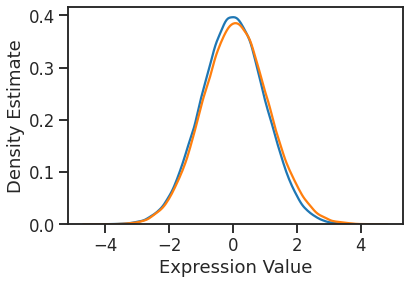

In [ ]:
#Kernel Density estimates of the two distributions across all genes
sns.kdeplot(Y.iloc[range(halfcells),:].values.flatten())
sns.kdeplot(Y.iloc[halfcells+1:,:].values.flatten())  # This is the true label (didn't use the psuedo wrong labels we've generated in the last step)
plt.xlabel('Expression Value')
plt.ylabel('Density Estimate')

Text(0, 0.5, 'Expression')

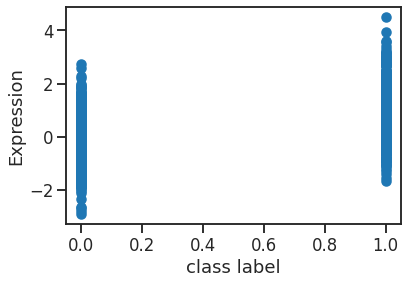

In [ ]:
#plot a single gene as a function of class membership
plt.scatter(X['class'],Y[0])
plt.xlabel('class label')
plt.ylabel('Expression')

## Here uses a simple linear regression to approximate the label (class)

In [ ]:
#Fit regression model
lm=sklearn.linear_model.Ridge()
lm.fit(X,Y)
B=pd.DataFrame(lm.coef_)

In [ ]:
B

,0
0,0.982081
1,0.964650
2,0.929859
3,1.029484
4,0.985953
...,...
195,-0.003588
196,-0.022062
197,0.014822
198,-0.031226


Text(0, 0.5, 'Coefficient')

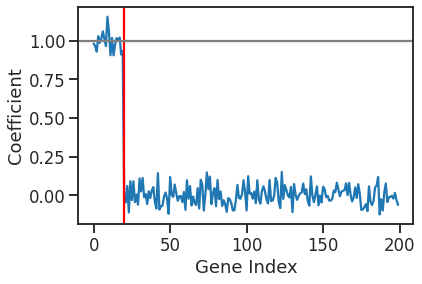

In [ ]:
#coefficients for informative subset of genes
plt.plot(B[0])
plt.axvline(ngenes*informativegenes,c='red')
plt.axhline(effectsize,c='gray')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')

In [ ]:
#Adjust covariates based on fitted coefficients
X_adjust=bayes_cov_col(Y,X,['class'],lm)

In [ ]:
X_adjust

,class
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
995,0.999929
996,0.998460
997,0.999998
998,0.995965


Text(0, 0.5, 'Class Probability')

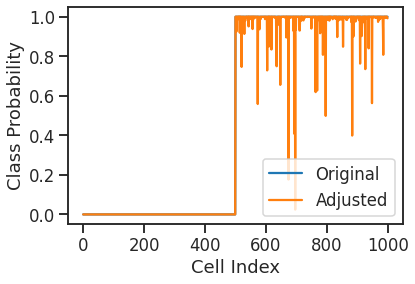

In [ ]:
#Plot original and adjusted covariates
plt.plot(X,label='Original')
plt.plot(X_adjust,label='Adjusted')
plt.legend(loc='lower right')
plt.xlabel('Cell Index')
plt.ylabel('Class Probability')

Text(0, 0.5, 'Class Probability')

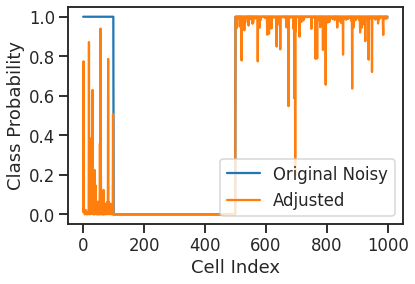

In [ ]:
#Fit regression model on noisy covariates (note how the first ten percent of cells are mostly reclassified as class 0)
lm_noise=sklearn.linear_model.Ridge()
lm_noise.fit(X_noise,Y)
B_noise=pd.DataFrame(lm_noise.coef_)
X_adjust_noise=bayes_cov_col(Y,X_noise,['class'],lm_noise)
plt.plot(X_noise,label='Original Noisy')
plt.plot(X_adjust_noise,label='Adjusted')
plt.legend(loc='lower right')
plt.xlabel('Cell Index')
plt.ylabel('Class Probability')

In [ ]:
lm_noise_adjust=sklearn.linear_model.Ridge()
lm_noise_adjust.fit(X_adjust_noise,Y)
B_noise_adjust=pd.DataFrame(lm_noise_adjust.coef_)

In [ ]:
lm_noise_adjust=sklearn.linear_model.Ridge()
lm_noise_adjust.fit(X_adjust_noise,Y)
B_noise_adjust=pd.DataFrame(lm_noise_adjust.coef_)

Text(0, 0.5, 'Coefficient')

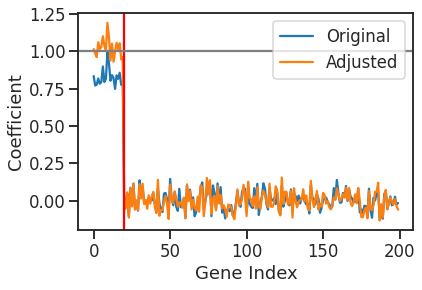

In [ ]:
#plot coefficients for informative subset of genes
plt.plot(B_noise[0],label='Original')
plt.plot(B_noise_adjust[0],label='Adjusted')
plt.axvline(ngenes*informativegenes,c='red')
plt.axhline(effectsize,c='gray')
plt.legend(loc='upper right')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')

# Apply this to our real perturb data

## Prepare data in the correct format

The bayesian function expect the expression matrix in such format


    @Y    = Expression matrix, cells x x genes, expecting pandas dataframe
    @X    = Covariate matrix, cells x covariates, expecting pandas dataframe
    @cols = The subset of columns that the EM should be performed over, expecting list
    @lm   = linear model object

### Prepare expression matrix Y

The original sparce matrix is cells by genes, so we don't need to transpose it.

Just convert sparse matrix to a pandas DataFrame with header and index.


In [ ]:
sc_object.X

<16585x15125 sparse matrix of type '<class 'numpy.float32'>'
	with 11243060 stored elements in Compressed Sparse Row format>

In [ ]:
# Convert sparse matrix to pandas dataframe and add index and column names to it
Y = pd.DataFrame.sparse.from_spmatrix(sc_object.X.copy())
Y.index = sc_object.obs.index.copy()
Y.columns = sc_object.var.index.copy()
Y.head()

,BET1L,RIC8A,SIRT3,PSMD13,ATHL1,LOC103241759,IFITM1,LOC103241765,IFITM3,B4GALNT4,PKP3,SIGIRR,PTDSS2,RNH1,HRAS,LRRC56,C1H11orf35,RASSF7,LOC103222129,PHRF1,IRF7,SCT,DEAF1,TMEM80,EPS8L2,TALDO1,PDDC1,SLC25A22,LOC103233437,PIDD1,RPLP2,PNPLA2,EFCAB4A,CD151,POLR2L,TSPAN4,CHID1,AP2A2,TOLLIP,BRSK2,...,NKRF,SEPT6,RPL39,UPF3B,RNF113A,NDUFA1,AKAP14,NKAP,RHOXF2,ZBTB33,LAMP2,CUL4B,MCTS1,C1GALT1C1,LOC103247367,THOC2,LOC103247374,XIAP,STAG2,TENM1,DCAF12L2,LOC103247401,KLHL13,WDR44,LOC103247415,LOC103247421,LOC103247423,LOC103247428,RPL10,DNASE1L1,TAZ,ATP6AP1,GDI1,FAM50A,LOC103247442,RPGR,LOC103247444,DDX3Y,LOC103247455,SARS-CoV-2
AAACCCAAGGTAATCA-1-SARS2,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.696860,0.696860,0.696860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.393719,0.0,0.0,0.0,0.0,1.558225,0.0,0.0,0.696860,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,1.206996,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.696860,0.0,0.0,0.00000,0.0,0.0,0.69686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.512563,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.696860
AAACCCAAGTTGGAGC-1-SARS2,0.000000,0.47135,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.666590,0.471350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.816402,0.0,0.0,0.0,0.0,1.154567,0.0,0.0,0.816402,0.816402,0.471350,0.47135,0.0,0.0,0.0,...,0.0,0.0,1.632805,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.47135,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.943580,0.0,0.0,0.666590,0.000000,0.666590,0.0,0.0,0.0,0.0,0.0,0.942700
AAACCCAGTGGTGATG-1-SARS2,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.007623,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.712497,1.007623,0.00000,0.0,0.0,0.0,...,0.0,0.0,1.234081,0.0,0.0,0.712497,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.468161,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2.665919
AAACGAAAGACCCGCT-1-SARS2,0.735153,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.735153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.735153,0.0,0.0,0.0,0.0,0.735153,0.0,0.0,0.735153,1.643851,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,1.273322,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.945031,0.0,0.0,0.735153,0.000000,0.735153,0.0,0.0,0.0,0.0,0.0,1.039663
AAACGAAAGGAAAGGT-1-SARS2,0.000000,0.00000,0.0,0.0,0.0,0.0,0.606529,0.0,0.0,0.0,0.606529,0.0,0.606529,0.857762,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.356240,0.0,0.0,0.0,0.0,0.606529,0.0,0.0,0.857762,0.857762,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.606529,0.0,0.0,0.606529,0.0,0.0,0.0,0.0,0.0,0.0,0.606529,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.606529,3.151618,0.0,0.0,0.000000,0.606529,0.000000,0.0,0.0,0.0,0.0,0.0,2.011630


### Prepare covariate matrix 

Just use the meta file as this covariate matrix, of course we won't use all of the variables in it. The used variables will be specified in the next parameter

Also we need to convert the label information into a one-hot encoding matrix

In [ ]:
X = sc_object.obs.copy()
X

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,feature_call,raw_scv2,Infected,new_feature_call,sgRNA,size,labels
AAACCCAAGGTAATCA-1-SARS2,SARS2,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064,3,ACE2-4,1.0,Bystander,ACE2,ACE2,4,ACE2
AAACCCAAGTTGGAGC-1-SARS2,SARS2,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699,2,KDM6A-1,4.0,Bystander,KDM6A,Other guide,1,KDM6A
AAACCCAGTGGTGATG-1-SARS2,SARS2,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068,9,nan,14.0,Infected,None,None,1,nan
AAACGAAAGACCCGCT-1-SARS2,SARS2,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054,3,SMARCA4-1,2.0,Bystander,SMARCA4,Other guide,1,SMARCA4
AAACGAAAGGAAAGGT-1-SARS2,SARS2,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310,3,nan,11.0,Infected,None,None,1,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,MOCK,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283,1,nan,0.0,Mock,None,None,1,nan
TTTGTTGTCACCGCTT-1-MOCK,MOCK,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383,0,nan,0.0,Mock,None,None,1,nan
TTTGTTGTCCACTTTA-1-MOCK,MOCK,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331,0,PHF6-4,0.0,Mock,PHF6,Other guide,1,PHF6
TTTGTTGTCTCCGAGG-1-MOCK,MOCK,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556,4,nan,0.0,Mock,None,None,1,nan


In [ ]:
# Get one-hot encoding
y = pd.get_dummies(X.labels)

In [ ]:
cols = list(y.columns)

In [ ]:
X = pd.merge(X, y, left_index = True, right_index= True)

In [ ]:
X['batch'].value_counts()

MOCK     12487
SARS2     4098
Name: batch, dtype: int64

In [ ]:
X['Infected'].value_counts()

Mock         12487
Bystander     2202
Infected      1896
Name: Infected, dtype: int64

In [ ]:
"""
map_class_labels = pd.DataFrame(X['labels'].value_counts())#.to_dict()
map_class_labels["labels"] = np.ones(len(X['labels'].value_counts()))#np.arange(len(X['labels'].value_counts()))
map_class_labels = map_class_labels.to_dict()
map_class_labels = map_class_labels['labels']
map_class_labels['nan'] = 0
"""

In [ ]:
# Convert the string levels into integer levels
map_class_batch = {"SARS2" : 0, "MOCK" : 1}
map_class_infected = {"Bystander" : 0, "Mock" : 1, "Infected": 3}

X['batch'] = X['batch'].map(map_class_batch)
X['Infected'] = X['Infected'].map(map_class_infected)
#X['labels'] = X['labels'].map(map_class_labels)

In [ ]:
X['batch'] = X['batch'].astype('int64')#.astype('category', ordered=True)
X['Infected'] = X['Infected'].astype('int64')#.astype('category', ordered=True)
#X['labels'] = X['labels'].astype('int64')#.astype('category', ordered=True)

In [ ]:
X

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,feature_call,raw_scv2,Infected,new_feature_call,sgRNA,size,labels,ACE2,ACVR1B,ADAM17,ANPEP,ARID1A,ATRX,CABIN1,CTSL,DOLK,DPF2,DPP4,DYRK1A,JMJD6,KDM6A,LOC103223006,PCBD1,PHF6,PHIP,PIAS1,PIAS2,RAD54L2,SH3YL1,SIAH1,SMAD3,SMAD4,SMARCA4,SMARCA5,SMARCE1,TMPRSS2,TMPRSS4,TMX3,UBXN7,nan
AAACCCAAGGTAATCA-1-SARS2,0,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064,3,ACE2-4,1.0,0,ACE2,ACE2,4,ACE2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAAGTTGGAGC-1-SARS2,0,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699,2,KDM6A-1,4.0,0,KDM6A,Other guide,1,KDM6A,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAGTGGTGATG-1-SARS2,0,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068,9,nan,14.0,3,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
AAACGAAAGACCCGCT-1-SARS2,0,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054,3,SMARCA4-1,2.0,0,SMARCA4,Other guide,1,SMARCA4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
AAACGAAAGGAAAGGT-1-SARS2,0,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310,3,nan,11.0,3,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,1,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283,1,nan,0.0,1,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTGTTGTCACCGCTT-1-MOCK,1,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383,0,nan,0.0,1,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTGTTGTCCACTTTA-1-MOCK,1,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331,0,PHF6-4,0.0,1,PHF6,Other guide,1,PHF6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TTTGTTGTCTCCGAGG-1-MOCK,1,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556,4,nan,0.0,1,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Prepare cols
The subset of columns that the EM should be performed over, a list.

In [ ]:
cols = cols + ["batch", "Infected",]

### Prepare the linear model object


In [ ]:
X.loc[:,cols]

,ACE2,ACVR1B,ADAM17,ANPEP,ARID1A,ATRX,CABIN1,CTSL,DOLK,DPF2,DPP4,DYRK1A,JMJD6,KDM6A,LOC103223006,PCBD1,PHF6,PHIP,PIAS1,PIAS2,RAD54L2,SH3YL1,SIAH1,SMAD3,SMAD4,SMARCA4,SMARCA5,SMARCE1,TMPRSS2,TMPRSS4,TMX3,UBXN7,nan,batch,Infected
AAACCCAAGGTAATCA-1-SARS2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAAGTTGGAGC-1-SARS2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAGTGGTGATG-1-SARS2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
AAACGAAAGACCCGCT-1-SARS2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
AAACGAAAGGAAAGGT-1-SARS2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
TTTGTTGTCACCGCTT-1-MOCK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
TTTGTTGTCCACTTTA-1-MOCK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
TTTGTTGTCTCCGAGG-1-MOCK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


In [ ]:
#Fit regression model
lm=sklearn.linear_model.Ridge()
lm.fit(X.loc[:,cols],Y)
B=pd.DataFrame(lm.coef_)

## Visualize the coefficient

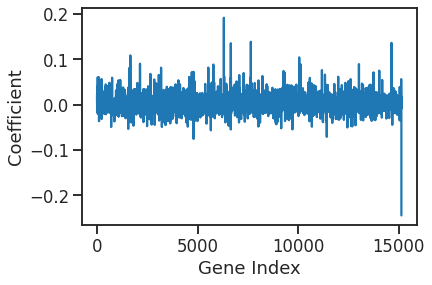

In [ ]:
#coefficients for informative subset of genes
plt.plot(B[0])
#plt.axvline(ngenes*informativegenes,c='red')
#plt.axhline(effectsize,c='gray')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')
plt.show()

In [ ]:
X_adjust=bayes_cov_col(Y, X.loc[:,cols] , cols, lm)

In [ ]:
X

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,feature_call,raw_scv2,Infected,new_feature_call,sgRNA,size,labels,ACE2,ACVR1B,ADAM17,ANPEP,ARID1A,ATRX,CABIN1,CTSL,DOLK,DPF2,DPP4,DYRK1A,JMJD6,KDM6A,LOC103223006,PCBD1,PHF6,PHIP,PIAS1,PIAS2,RAD54L2,SH3YL1,SIAH1,SMAD3,SMAD4,SMARCA4,SMARCA5,SMARCE1,TMPRSS2,TMPRSS4,TMX3,UBXN7,nan
AAACCCAAGGTAATCA-1-SARS2,0,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064,3,ACE2-4,1.0,0,ACE2,ACE2,4,ACE2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAAGTTGGAGC-1-SARS2,0,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699,2,KDM6A-1,4.0,0,KDM6A,Other guide,1,KDM6A,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCCAGTGGTGATG-1-SARS2,0,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068,9,nan,14.0,3,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
AAACGAAAGACCCGCT-1-SARS2,0,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054,3,SMARCA4-1,2.0,0,SMARCA4,Other guide,1,SMARCA4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
AAACGAAAGGAAAGGT-1-SARS2,0,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310,3,nan,11.0,3,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,1,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283,1,nan,0.0,1,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTGTTGTCACCGCTT-1-MOCK,1,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383,0,nan,0.0,1,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TTTGTTGTCCACTTTA-1-MOCK,1,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331,0,PHF6-4,0.0,1,PHF6,Other guide,1,PHF6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TTTGTTGTCTCCGAGG-1-MOCK,1,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556,4,nan,0.0,1,None,None,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
X_adjust

,ACE2,ACVR1B,ADAM17,ANPEP,ARID1A,ATRX,CABIN1,CTSL,DOLK,DPF2,DPP4,DYRK1A,JMJD6,KDM6A,LOC103223006,PCBD1,PHF6,PHIP,PIAS1,PIAS2,RAD54L2,SH3YL1,SIAH1,SMAD3,SMAD4,SMARCA4,SMARCA5,SMARCE1,TMPRSS2,TMPRSS4,TMX3,UBXN7,nan,batch,Infected
AAACCCAAGGTAATCA-1-SARS2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTTGGAGC-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTGGTGATG-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
AAACGAAAGACCCGCT-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGGAAAGGT-1-SARS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5
TTTGTTGTCACCGCTT-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5
TTTGTTGTCCACTTTA-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5
TTTGTTGTCTCCGAGG-1-MOCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5


In [ ]:
X_adjust['ACE2'].value_counts()
#X['ACE2'].value_counts()

0.0    16138
0.5      447
Name: ACE2, dtype: int64

In [ ]:
X['ACE2'].value_counts()

0    16138
1      447
Name: ACE2, dtype: int64

# **Based on the results in the above two cells, we see that the adjusted label just gave the 100% accurate prediction, which make me feel the current label is the version that has already corrected by the same algorithm**

In [ ]:
X_adjust['labels'].value_counts()
#X['labels'].value_counts()

0.0    10151
0.5     6434
Name: labels, dtype: int64

In [ ]:
pd.DataFrame(X.loc[:,'labels'] - X_adjust.loc[:,'labels']).value_counts()

labels
0.0       10151
0.5        6434
dtype: int64

In [ ]:
#Plot original and adjusted covariates
plt.plot(X.loc[:,'labels'],label='Original')
plt.plot(X_adjust.loc[:,'labels'],label='Adjusted')
plt.legend(loc='lower right')
plt.xlabel('Cell Index')
plt.ylabel('Class Probability')


In [ ]:
B[1]

0        0.016748
1        0.045969
2       -0.000631
3        0.056789
4       -0.003684
           ...   
15120   -0.000040
15121   -0.000202
15122   -0.000901
15123   -0.000251
15124   -0.638202
Name: 1, Length: 15125, dtype: float64

In [ ]:
from numpy import array
from scipy.sparse import coo_matrix
row  = array([0, 0, 1, 3, 1, 0, 0])
col  = array([0, 2, 1, 3, 1, 0, 0])
data = array([1, 1, 1, 1, 1, 1, 1])
A = coo_matrix((data, (row, col)), shape=(4, 4)).tocsc()

In [ ]:
A

<4x4 sparse matrix of type '<class 'numpy.longlong'>'
	with 4 stored elements in Compressed Sparse Column format>